In [7]:
import numpy as np
import gzip, pickle
import pandas as pd

patients = pd.read_csv('internacoes_charlson_zero.csv.gz', compression='gzip', nrows=None, verbose=True)
target = patients['target'].values
patients_full = patients['text'].values
patients.shape, patients.columns

Tokenization took: 25853.27 ms
Type conversion took: 13997.81 ms
Parser memory cleanup took: 0.01 ms


((48907, 9),
 Index(['text', 'target', 'reg', 'days', 'dias', 'dtini', 'dtend', 'evolucoes',
        'wc'],
       dtype='object'))

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

import nltk
nltk.download('rslp')
nltk.download('stopwords')

import nltk.stem
portuguese_stemmer = nltk.stem.RSLPStemmer()
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer,self).build_analyzer()
        return lambda doc: (portuguese_stemmer.stem(w) for w in analyzer(doc))

stopwords = stopwords.words("portuguese")

tfidf_model = TfidfVectorizer(max_features=5000, stop_words=stopwords, ngram_range=(1, 1), norm='l1')
data = tfidf_model.fit_transform(patients_full)
print(data.shape)

[nltk_data] Downloading package rslp to /home/jovyan/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(48907, 5000)


In [9]:
with gzip.open("model_5k_unigram.pkl.gz", "wb") as wfp:   #Pickling
    pickle.dump(tfidf_model, wfp)
    wfp.close()

In [10]:
with gzip.open("data_5k_unigram.npy.gz", "wb") as d_wfp:   #Pickling
    pickle.dump(data, d_wfp)
    d_wfp.close()

In [11]:
with gzip.open("target_unigram.pkl.gz", "wb") as t_wfp:   #Pickling
    pickle.dump(target, t_wfp)
    t_wfp.close()

In [12]:
data = data.todense()
target = np.asarray(target)

In [13]:
freq_char = {}
for key in target:
    if key in freq_char:
        freq_char[key] += 1
    else:
        freq_char[key] = 1
freq_char

{0.0: 18407,
 1.0: 2116,
 2.0: 4680,
 3.0: 6099,
 4.0: 5121,
 5.0: 2512,
 6.0: 4087,
 7.0: 1831,
 8.0: 1831,
 9.0: 975,
 10.0: 688,
 11.0: 278,
 12.0: 126,
 13.0: 63,
 14.0: 51,
 15.0: 20,
 16.0: 6,
 17.0: 8,
 18.0: 6,
 21.0: 1,
 23.0: 1}

In [15]:
import time
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

kfold = KFold(n_splits=10)

values = []
prediction = []
models = []
maes = []

for train, test in kfold.split(data, target):

    start = time.time()
    model = RandomForestRegressor(n_jobs=-1)
    
    model.fit(data[train], target[train])
    target_pred = model.predict(data[test])
    mae = mean_absolute_error(target[test], target_pred)
    
    values.extend(target[test])
    prediction.extend(target_pred)
    models.append(model)
    maes.append(mae)

    print('mean_absolute_error: ', round(mae,4), round(time.time() - start,2))
    #RandomForestRegressor 1.8897 73.17
    #ExtraTreesRegressor 
    #GradientBoostingRegressor
    

mean_absolute_error:  0.7501 508.84
mean_absolute_error:  0.9145 366.11
mean_absolute_error:  1.0641 401.25
mean_absolute_error:  1.3129 384.64
mean_absolute_error:  1.3657 491.2
mean_absolute_error:  1.3901 452.1
mean_absolute_error:  1.5692 462.09
mean_absolute_error:  1.7267 455.29
mean_absolute_error:  1.7092 462.12
mean_absolute_error:  2.3269 477.85


In [16]:
'MAEs: ', np.mean(maes)

('MAEs: ', 1.4129577367386115)

In [17]:
#patients['predict'] = prediction
#patients.to_csv('internacoes_charlson_zero.csv.gz', compression='gzip', index=False)
#print(patients.shape)

In [18]:
tuples = np.stack((values,np.round(prediction,1)), axis=-1) ## ROUND TUPLES

frequencies = {}
for x,y in tuples:
    key = (x, y)
    if key in frequencies:
        frequencies[key] += 1
    else:
        frequencies[key] = 1

size = []
x = []
y = []
for key in frequencies.keys():
    size.append(frequencies[key])
    x.append(key[0])
    y.append(key[1])

In [19]:
np.max(values), np.max(x), np.max(y)

(23.0, 23.0, 11.9)

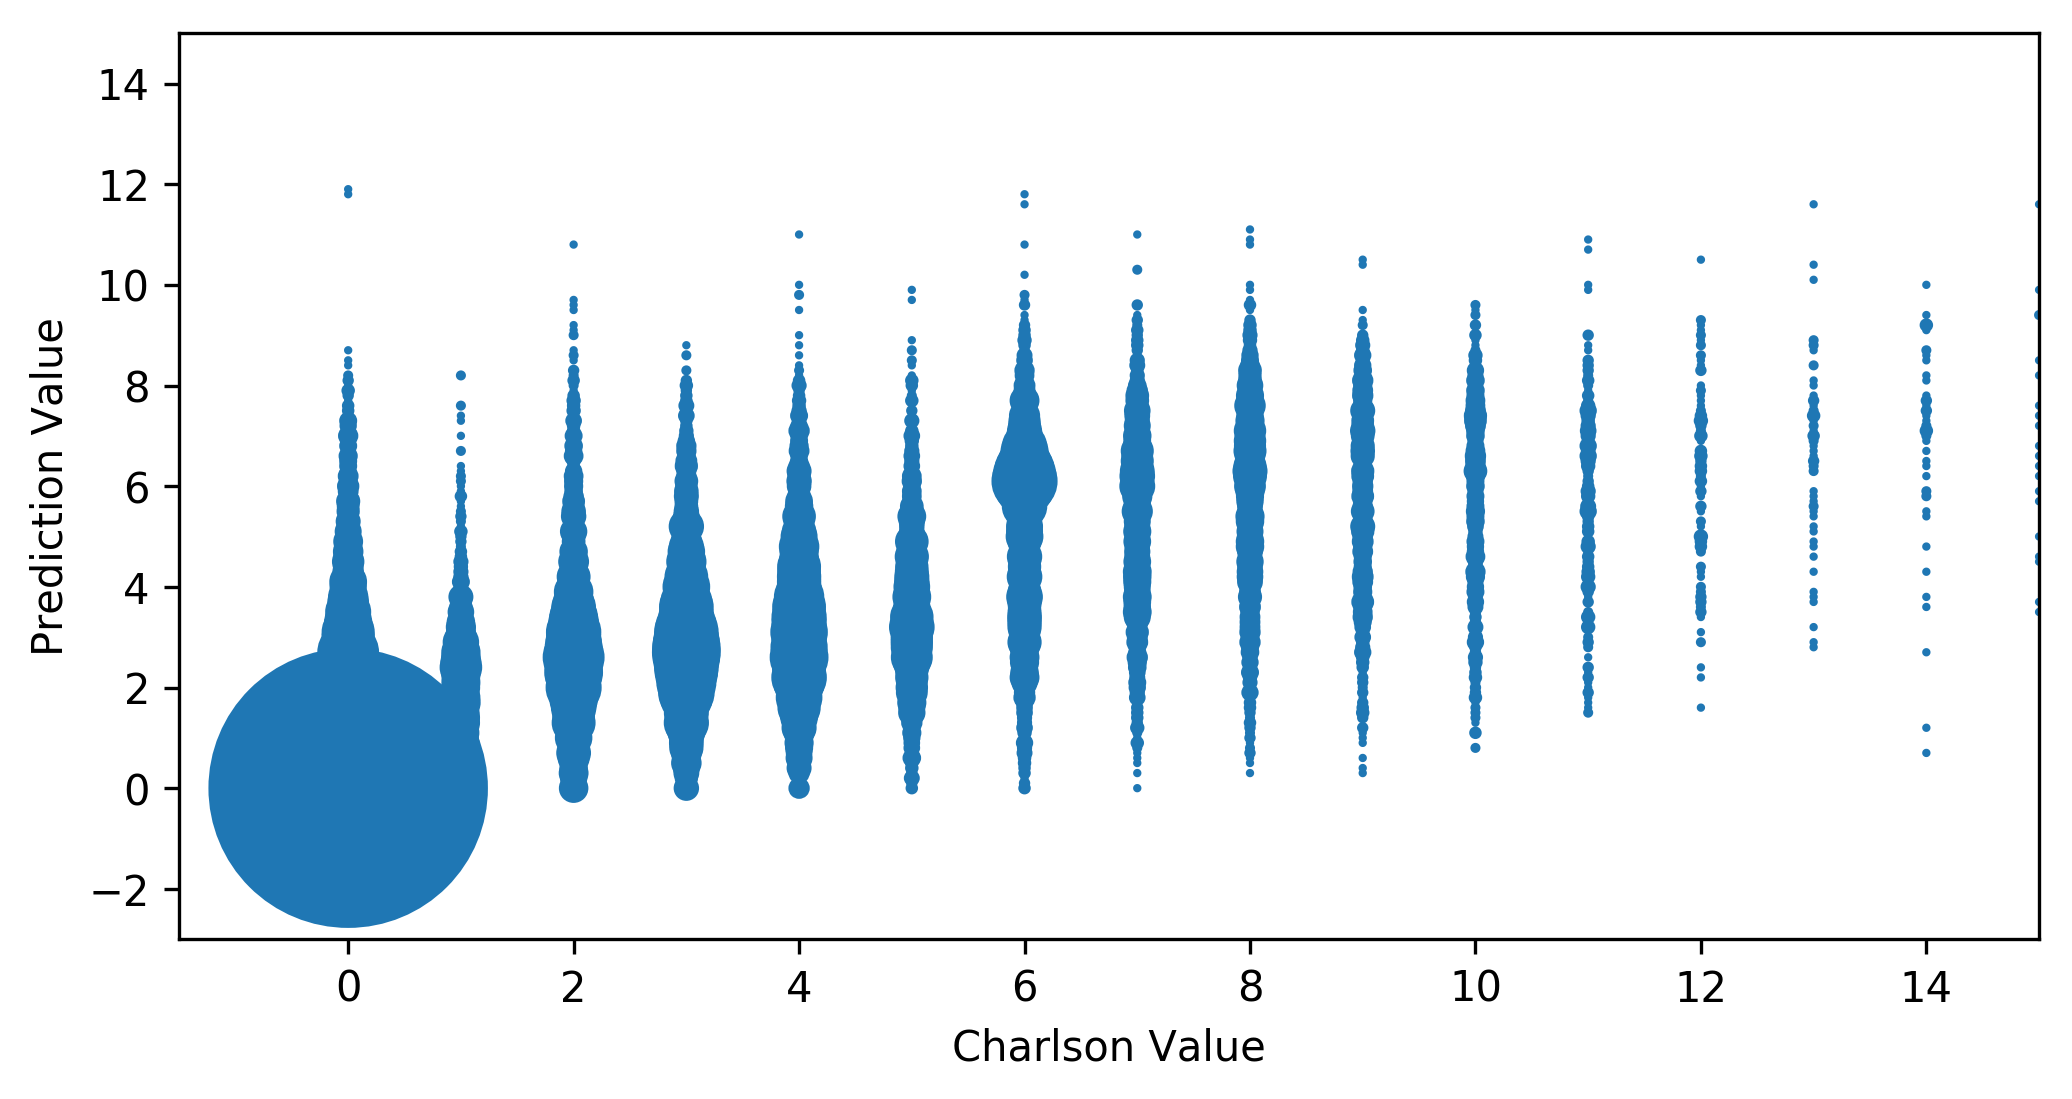

In [20]:
# https://matplotlib.org/gallery/shapes_and_collections/scatter.html
%matplotlib inline
import matplotlib.pyplot as plt

maxX = np.max(x)

plt.figure(figsize=(8, 4), dpi= 300)
plt.xlabel('Charlson Value', fontsize=10)
plt.ylabel('Prediction Value', fontsize=10)
#plt.xticks(range(int(maxX)+1))
#plt.yticks(range(int(maxX)+1))
plt.xlim(-1.5,15)
plt.ylim(-3,15)

plt.scatter(x,y,s=size)
plt.show()

In [21]:
import operator, sys

features = {}
ridx = {idx:term for term,idx in tfidf_model.vocabulary_.items()}
for model in models:
    for i,v in enumerate(model.feature_importances_):
        if not ridx[i] in features.keys():
            features[ridx[i]] = v
        else:
            features[ridx[i]] += v
        if (i % 1000) == 0:
            sys.stdout.write(str(i) + ', ')
            sys.stdout.flush()

0, 1000, 2000, 3000, 4000, 0, 1000, 2000, 3000, 4000, 0, 1000, 2000, 3000, 4000, 0, 1000, 2000, 3000, 4000, 0, 1000, 2000, 3000, 4000, 0, 1000, 2000, 3000, 4000, 0, 1000, 2000, 3000, 4000, 0, 1000, 2000, 3000, 4000, 0, 1000, 2000, 3000, 4000, 0, 1000, 2000, 3000, 4000, 

In [22]:
sorted(features.items(), key=operator.itemgetter(1), reverse=True)[:20]

[('oncologia', 1.3813313355892691),
 ('imunodeficiencia', 1.1553682872014448),
 ('estadiamento', 0.3279362139191858),
 ('dm', 0.25640756087063044),
 ('sida', 0.18085659025260828),
 ('beg', 0.1805521471884464),
 ('cd4', 0.17423306123305543),
 ('irc', 0.1431804768692067),
 ('cirrose', 0.13790702164692567),
 ('diabetes', 0.1313118362195819),
 ('paliativo', 0.11025358500577156),
 ('has', 0.09514821449274444),
 ('neoplasia', 0.08665546152857458),
 ('maligna', 0.08466985817857689),
 ('avc', 0.06413763183822846),
 ('dpoc', 0.06188975033912921),
 ('fe', 0.05439623888274879),
 ('cv', 0.053167292701345355),
 ('abdominal', 0.052598748294839855),
 ('implantes', 0.052549085193532484)]

In [23]:
with gzip.open("features_5k_multigram.pkl.gz", "wb") as wfp:   #Pickling
    pickle.dump(features, wfp)
    wfp.close()